# Deep Q Learning with PyTorch

This tutorial shows how to use PyTorch to train an neural network *agent* that learns to control a cartpole. We use OpenAI's gym environment to simulate this task.

### Task

The agent has to decide to move a cart left or right, so that the pole attached to it stays upright. Many people have succesfully trained such an agent to do this task. You can find an official leaderboard with various algorithms and visualizations [at the AI Gym website](https://gym.openai.com/envs/CartPole-v0).

![cartpole](images/cartpole.gif)

This task is designed so that the input are 4 real values representing the environment state (accelerations, etc.).

However this seems a bit boring, so we'll use a visual screen patch centered on the cart as an input. Because of this, our results aren't directly comparabe to the ones from an official leaderboard - our task is harder.

Because our modified challenge is harder, the training is slower, because we have to render all the frames.

### Packages

First, let's import needed packages. From PyTorch, we'll use:

* [automatic differentiation package (`torch.autograd`)](http://pytorch.org/docs/autograd.html)
* [neural network package (`torch.nn`)](http://pytorch.org/docs/nn.html)
* [optimization package (`torch.optim`)](http://pytorch.org/docs/autograd.html)
* [package with utilities for vision tasks (`torchvision`)](https://github.com/pytorch/vision)

In [8]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v0')

INFO:gym.envs.registration:Making new env: CartPole-v0
[2017-01-04 22:29:33,699] Making new env: CartPole-v0


In [9]:
from IPython import display
%matplotlib inline

### Replay memory

We'll be using experience replay for training our DQN Agent. The agent will store it's past experiences in a memory, and replay it's past memory randomly to train itself. This is done so that while training, the samples in a mini-batch are decorrelated. This is a technique that has been shown to greatly stabilize the training of DQN agents.

For this, we're going to need two classses:

* `Transition` - a named tuple representing a single transition in our environment
* `ReplayMemory` - a cyclic buffer of bounded size that holds the transitions observed recently. 
   * It also implements a `.sample()` method for selecting a random batch of transitions for training.

In [10]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None) 
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

Now, let's define our model. But first, let quickly recap Deep-Q Learning

### The DQN algorithm

*Our world is deterministic, so all equations presented here are also assuming determinism of the process.*

Our aim will be to train a policy that tries to maximize the discounted reward 

> $R_{t_0} = \sum_{t=t_0}^{\infty} r_t \gamma^{t - t_0}$. 

$\gamma$ should be a constant between $0$ and $1$. This ensures that the sum converges, and makes the rewards from the uncertain far future be less important for our agent than the ones it can be fairly confident about.

The main idea behind Q-learning is that if we had a function $Q^*: State \times Action \rightarrow \mathbb{R}$, that could tell us what would our discounted reward be, if we were to take an action in a given state, we could easily construct a policy that maximizes our rewards:

$$\pi^*(s) = \mathrm{argmax}_a \ Q^*(s, a)$$

However, we don't know everything about the world, so we don't have access to $Q^*$, but since neural networks are universal function approximators, we can simply create one and train it to resemble the $Q^*$.

For our training update rule, we'll use a fact that every $Q$ function for some policy obeys the Bellman equation.

$$Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))$$

Our loss will be a mean squared error between the two sides of the equality (where $B$ is a batch of transitions):

$$L = \frac{1}{|B|}\sum_{(s, a, s', r) \ \in \ B} (Q(s, a) - (r + \gamma \max_a Q(s', a)))^2$$

### Q-network

Our model will be a ConvNet that takes in a difference between the current screen patch, and the previous one. This will allow it to take the velocity of the pole into account. 

It has two outputs representing $Q(s, \mathrm{left})$ and $Q(s, \mathrm{right})$ (where $s$ is the input to the network).

In [11]:
class DQN(nn.Container):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(288, 2)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

### Input extraction

The code below are utilities for extracting and processing rendered images from the env. 

It uses the `torchvision` package, which makes it easy to compose image transforms. 

Once you run the cell, it will display an example patch that it extracted.

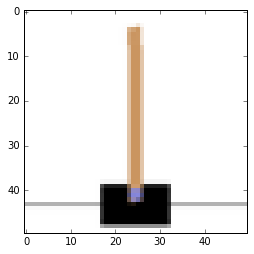

In [12]:
resize = T.Compose([T.ToPILImage(), T.Scale(50, interpolation=Image.CUBIC), T.ToTensor()])

# This is based on the code from gym.
screen_width = 600
def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0) # MIDDLE OF CART
    
    
def get_screen():
    screen = env.render(mode='rgb_array').transpose((2, 0, 1)) # transpose into torch order (CHW)
    view_width = 160
    # Strip off the top and bottom of the screen
    screen = screen[:, 160:160+view_width]
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width,None)
    else:
        slice_range = slice(cart_location - view_width // 2, cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescare, convert to torch tensor (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)


plt.imshow(get_screen().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
plt.show()

### Training hyperparameters and utilities

This cell instantiates our model and its optimizer, and defines some utilities:

* `Variable` - this is a simple wrapper around `torch.autograd.Variable` that will automatically send the data to the GPU every time we construct a Variable.
* `select_action` - will select an action accordingly to an epsilon greedy policy. Simply put, we'll sometimes use our model for choosing the action, and sometimes we'll just sample one uniformly. The probability of choosing a random action will start at `EPS_START` and will decay exponentially towards `EPS_END`. `EPS_DECAY` controls the rate of the decay.
* `plot_durations` - a helper for plotting the durations of episodes, along with an average over the last 100 episodes (the measure used in the official evaluations). The plot will be underneath the cell containing the main training loop, and will update after every episode.

In [13]:
BATCH_SIZE = 32
GAMMA = 0.97
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 70
USE_CUDA = False


model = DQN()
memory = ReplayMemory(10000)
optimizer = optim.Adam(model.parameters())


class Variable(autograd.Variable):
    def __init__(self, data, *args, **kwargs):
        if USE_CUDA:
            data = data.cuda()
        super(Variable, self).__init__(data, *args, **kwargs)


steps_done = 0
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        return model(Variable(state, volatile=True)).data.max(1)[1]
    else:
        return torch.LongTensor([[random.randrange(2)]])
    

episode_durations = []
def plot_durations():
    plt.figure(1)
    plt.clf()
    durations_t = torch.Tensor(episode_durations)
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    display.clear_output(wait=True)
    display.display(plt.gcf())

### Training loop

Finally, the code for training our model.

At the top you can find an `optimize_model` function that performs a single step of the optimization. It first samples a batch, concatenates all the tensors into a single one, computes $Q(s_t, a_t)$ and $V(s_{t+1}) = \max_a Q(s_{t+1}, a)$, and combines them into our loss. There's some complication because of the final states, for which $V(s) = 0$.

Below, you can find the main training loop. At the beginning we reset the env and initialize the `state` variable. Then, we sample an action, execute it, observe the next screen and the reward (always 1), and optimize our model once. When the episode ends (our model fails), we restart the loop.

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for detailed explanation).
    batch = Transition(*zip(*transitions)) 

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))
    non_final_next_states = Variable(torch.cat(tuple(s for s in batch.next_state if s is not None)))
    state_batch = Variable(torch.cat(batch.state))
    action_batch = Variable(torch.cat(batch.action))
    reward_batch = Variable(torch.cat(batch.reward))

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken
    state_action_values = model(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = Variable(torch.zeros(BATCH_SIZE))
    next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0]
    next_state_values = next_state_values.detach() # don't send any gradients this way
    # Compute the discounted reward estimate
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute MSE cost
    loss = (state_action_values - expected_state_action_values).pow(2).mean()
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

for i_episode in count():
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action[0,0])
        reward = torch.Tensor([reward])
        
        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
            
        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        
        # Move to the next state
        state = next_state
        
        # Perform one step of the optimization
        optimize_model()
            
        if done:
            episode_durations.append(t+1)
            plot_durations()
            break